# Notebook for a Downstream RNA-Seq Analysis

Hello, this analysis workflow will enable you to process an existing RNA-Seq feature count matrix. At this point, you should have a feature count matrix (e.g. an nf-core rna-seq pipeline output), a TPM matrix, a design file and a model file to specify details for your differential gene expression comparisons. 

## Requirements
- A feature count matrix file (e.g. output of the nf-core rnaseq pipeline)
- A TPM file (e.g. output of the nf-core rnaseq pipeline)
- A design file specifiying the experimental design
- A model file specifying the statistical model for differential gene expression analyses

In this example, those files are read from the ../../../../data folder. 

## Outputs
Any pdf result figures this pipeline will produce by default (Heatmaps, MA-plots, volcano plots) will be deposited in the ../../../../outputs/html_local/report_figures folder. 

Feel free to add additonal modules to this data analysis. These days chatGPT does a great job at providing R-code templates for additional figures you might like to see in this analysis. 

# Getting Started

To run this notebook, please use the R422 kernel. This should aready be running an R422 should be visible in the top-right hand corner of this screen. 

If it is not, go to the Kernel tab > Change kernel and select R422 from the dropdown menu. 

The kernel specifications are as follows:

<ul>
<li>name: R422</li>
<li>channels:</li>
<li>  - conda-forge</li>
<li>dependencies:</li>
 <li> gcc_linux-64</li>
 <li> gfortran_linux-64</li>
 <li> gxx_linux-64</li>
 <li> r-base=4.2.2</li>
 <li> r-renv</li>
 <li> r-irkernel</li>
</ul>

Dataset used in this analysis: https://www.ebi.ac.uk/ena/browser/view/PRJEB23709
Alignment was done with Unison pipeline: [reference to pipeline]




In [209]:
# RNA-Seq pipeline outputs were transferred to the/data folder in this project
print(paste0("Input files for this project are located in the data folder: ", paste0(list.files("../../../../data"), collapse = ", ")))

[1] "Input files for this project are located in the data folder: rsem.all.gene_counts.tsv, rsem.all.gene_TPM.tsv"


# Creating or Loading the R-renv Environment for this Analysis
To ensure reproducibility of this analysis we'll use the R-packaging manager renv. It will allow us to keep track of R-packages and their versions, to ensure that this analysis is fully reproducible. For this example analysis, an renv environment has been created already. 

In [210]:
## Load helper function - will be moved to UnisonRtools package

source("helperFunctions.r")

In [211]:
## Load renv environment ##

loadProjectEnvironment()


* The library is already synchronized with the lockfile.
[1] "Renv environment restored from file"


In [212]:
###############################################################################
## Set project parameters                                                    ##

projectList <- list()

## First dataset
projectList[["First_RNAseq_Dataset"]] <- list(
    "dataset_id" =  "PRJEB23709",
    "primaryAlignmentGeneID" = "gene_id",
    "geneIDcolumn" = "gene_id",
    "datasetTitle" = "NEM dataset",
    "datasetAbstractURL" = "",
    "sampleSheetFile" = "/home/jovyan/data/GSE209801_test_default_star_rsem/data/RnaSeqpublicpipeline/PRJNA862500/run457/NfCorePipelineRnaseq/samplesheet.csv",
    "designFile" = NULL, # if you have a design file, provide a path here.
    "modelFile" = NULL,
    "multiQChtmlFile" = "path/To/Individual/MultiQC",
    "geneLevelFeatureCountFile" = "/home/jovyan/data/GSE209801_test_default_star_rsem/data/RnaSeqpublicpipeline/PRJNA862500/run457/NfCorePipelineRnaseq/rsem.merged.gene_counts.tsv",
    "geneLevelTPMfile" = "/home/jovyan/data/GSE209801_test_default_star_rsem/data/RnaSeqpublicpipeline/PRJNA862500/run457/NfCorePipelineRnaseq/rsem.merged.gene_tpm.tsv"
    )


project_id <- "RNA_Seq_NEM_Analysis_001"
primaryAlignmentGeneID <- "gene_id"
geneIDcolumn <- "gene_id"
NtopGenes <- 500

projectTitle <- "RNAseq NEM Analysis"
projectSubtitle <- "Analysis GSE209801"

projectAbstract <- "Examination of the effect of NEM treatment on cells"

projectAuthor <- "John Doe"

projectDir <- paste0(getwd(), "/")

workdir <- paste0("../../../../workdir/")

if (!dir.exists(workdir)){
    dir.create(workdir, recursive = TRUE)
}

htmlDir <- paste0("../../../../results/html_local/")

if (!dir.exists(htmlDir)){
    dir.create(htmlDir, recursive = TRUE)
}

tableDir <- paste0(htmlDir, "report_tables/")

if (!dir.exists(tableDir)){
    dir.create(tableDir)
}

figDir <- paste0(htmlDir, "report_figures/")

if (!dir.exists(figDir)){
    dir.create(figDir, recursive = TRUE)
}

figureCount <- 1

tableCount <- 1




## Done                                                                      ##
###############################################################################

# Create a design and model file for all experiments in this analysis
## Creating a design file

In [213]:
# Create design file based on sample sheet - manual editing required - 

for (i in 1:length(projectList)){
    if (is.null(projectList[[i]][["designFile"]])){
        sampleSheetFN <- projectList[[i]][["sampleSheetFile"]]
        dfSample <- read.delim(
            sampleSheetFN, 
            sep = ",",
            stringsAsFactors = F
        )

        dfDesign <- dfSample
        dfDesign[["sample.group"]] <- dfDesign[["sample"]]

        ## create comparisons ##
        
        
        names(dfDesign) <- gsub("^sample$", "sample.id", names(dfDesign))
        
        dfDesign$sample.group <- gsub("_[1-9]$", "",dfDesign$sample.group)

        dfDesign <- dfDesign[,c("sample.id", "sample.group")]

        dfDesign <- dfDesign[order(dfDesign$sample.group, decreasing = T), ]

        mComb <- combn(unique(dfDesign$sample.group),2)
       
        for (j in 1:ncol(mComb)){
            tag <- paste0("comp_", j)
            dfDesign[,tag] <- ""
            groupA <- mComb[1, j]
            groupB <- mComb[2,j]

            dfDesign[dfDesign$sample.group == groupA, tag] <- paste0("1_", groupA)
            dfDesign[dfDesign$sample.group == groupB, tag] <- paste0("2_", groupB)
        }
            print(dfDesign) 
        
         designFN <- paste0("../../design/design.table.dataset.",i,".txt")  
        write.table(dfDesign, designFN, sep="\t", row.names=F)
        projectList[[i]][["designFile"]] <- designFN
        print(paste0("Design file for experiment ", i, " written to file: ", designFN, ". You can open the design file and edit it before proceding. "))
    }
}


     

      sample.id sample.group        comp_1
1 NEN_treated_2  NEN_treated 1_NEN_treated
2 NEN_treated_3  NEN_treated 1_NEN_treated
5 NEN_treated_1  NEN_treated 1_NEN_treated
3        DMSO_2         DMSO        2_DMSO
4        DMSO_1         DMSO        2_DMSO
6        DMSO_3         DMSO        2_DMSO
[1] "Design file for experiment 1 written to file: ../../design/design.table.dataset.1.txt. You can open the design file and edit it before proceding. "


In [214]:
# Add DGE comparisons to design file

# Setting Parameters for this Analysis

# Loading of input files for this Workflow
## Loading the Design File

In [249]:
## Create unified design file

mergedDesignFile <- createUnifiedDesignFile(
    projectList = projectList
)

###############################################################################
## Add sample group colors if not provied                                    ##

mergedDesignFile$sample.group_color <- NULL

pos <- grep("sample.group_color", names(mergedDesignFile))
        
if (length(pos) == 0){
    sample.group <- unique(mergedDesignFile$sample.group)
    sample.group_color <- sample.group


            #library(scales)
    sample.group_color = scales::hue_pal()(length(sample.group_color))
            #sample.group_color = c("#990000", "#009900")
    
    ## set sample group colors manually
    

    dfGroupColors <- unique(data.frame(sample.group, sample.group_color))

    mergedDesignFile <- merge(mergedDesignFile, dfGroupColors, by.x = "sample.group", "sample.group")

}

 

pos <- grep("\\.1$", names(mergedDesignFile))
if (length(pos) > 0){
    mergedDesignFile <- mergedDesignFile[,-pos]
}

## Show unified design table
DT::datatable(mergedDesignFile)    

[1] "../../design/design.table.dataset.1.txt"
[1] "Design file loaded for project First_RNAseq_Dataset."
[1] "sample.id"    "sample.group" "comp_A1"      "dataset_id"  


HTML widgets cannot be represented in plain text (need html)

In [250]:
################################################################################
## Save design file                                                           ##
FNdesign <- "../../design/design.table.txt"

write.table(
    mergedDesignFile,
    FNdesign,
    row.names = F,
    sep = "\t"
)

print("Merged design file saved.")

## Merged design file saved                                                   ##
################################################################################

[1] "Merged design file saved."


In [251]:
################################################################################
## Create summary feature count matrix                                        ##
dfRSEM <- createUnifiedMatrix(
    projectList = projectList,
    fileType = "geneLevelFeatureCountFile"
)

##                                                                            ##
################################################################################


[1] "/home/jovyan/data/GSE209801_test_default_star_rsem/data/RnaSeqpublicpipeline/PRJNA862500/run457/NfCorePipelineRnaseq/rsem.merged.gene_counts.tsv"
[1] "Files loaded for project First_RNAseq_Dataset."
[1] "Merged feature count matrix for 6 samples created."


In [252]:
###############################################################################
## Save merged read count matrix                                             ##
FNrsemFull <- "../../../../data/rsem.all.gene_counts.tsv"


write.table(
    dfRSEM,
    FNrsemFull,
    sep = "\t",
    row.names = F
)

print(
    paste0(
        "Full count matrix saved in ",
        FNrsemFull,
        "."
    )
)
## Done   



[1] "Full count matrix saved in ../../../../data/rsem.all.gene_counts.tsv."


In [253]:
###############################################################################
## Create merged read TPM matrix                                             ##

dfTPM <- createUnifiedMatrix(
    projectList = projectList,
    fileType = "geneLevelTPMfile"
)

##                                                                            ##
################################################################################

[1] "/home/jovyan/data/GSE209801_test_default_star_rsem/data/RnaSeqpublicpipeline/PRJNA862500/run457/NfCorePipelineRnaseq/rsem.merged.gene_tpm.tsv"
[1] "Files loaded for project First_RNAseq_Dataset."
[1] "Merged feature count matrix for 6 samples created."


In [254]:
###############################################################################
## Save merged read count matrix                                             ##

## Fill might be too big to save:

FNtpmFull <- "../../../../data/rsem.all.gene_TPM.tsv"
write.table(
    dfTPM,
    FNtpmFull,
    sep = "\t",
    row.names = F
)

print(
    paste0(
        "Full count matrix saved in ",
        FNtpmFull,
        "."
        
    )
)
## Done   



[1] "Full count matrix saved in ../../../../data/rsem.all.gene_TPM.tsv."


In [255]:
###############################################################################
## Differential gene expression module                                       ##

# This module reads 
#   * a design file
#   * a model file 
#   * a RSEM read count matrix (rnaseq pipeline output)

# and produces the differential gene expression analyses specified in the 
# design/model files. 

# Outputs: DEseqw differential gene epxression output, written out as a text 
# file. 


## load relevant files
# Design file
FNdesign <- "../../design/design.table.txt"

dfDesign <- read.delim(
    file = FNdesign,
    sep = "\t",
    stringsAsFactors = F
)

dim(dfDesign)
print(dfDesign)

[1] 6 5

  sample.group     sample.id       comp_A1 dataset_id sample.group_color
1         DMSO        DMSO_2        2_DMSO PRJEB23709            #00BFC4
2         DMSO        DMSO_1        2_DMSO PRJEB23709            #00BFC4
3         DMSO        DMSO_3        2_DMSO PRJEB23709            #00BFC4
4  NEN_treated NEN_treated_2 1_NEN_treated PRJEB23709            #F8766D
5  NEN_treated NEN_treated_3 1_NEN_treated PRJEB23709            #F8766D
6  NEN_treated NEN_treated_1 1_NEN_treated PRJEB23709            #F8766D


## Loading the Raw Readcount Matrix

In [256]:
# RSEM count file


    #FNrsem <- "../../../../results/nfcoreRnaseq_GSE7820_Run001/star_rsem/rsem.merged.gene_counts.tsv"
    FNrsem <- "../../../../data/rsem.all.gene_counts.tsv"
    
    dfRSEM <- read.delim(
        file = FNrsem,
        sep = "\t",
        stringsAsFactors = F
    )



# the count file needs to be made into an integer count matrix
mRSEM <- dfRSEM

## Remove extra column
mRSEM$transcript_id.s. <- NULL

row.names(mRSEM) <- mRSEM$gene_id
mRSEM$gene_id <- NULL

# make sure it's integer, as required by DESeq2
mRSEM <- data.matrix(
    round(
        mRSEM
    )
)

dim(mRSEM)

[1] 29972     6

## Loading the TPM file

In [257]:
# TPM file
FNtpm <- "../../../../data/rsem.all.gene_TPM.tsv"

if (file.exists(FNtpm)){
    dfTPM <- read.delim(
        file = FNtpm,
        sep = "\t",
        stringsAsFactors = F
    )
}

dim(dfTPM)


[1] 29972     7

In [258]:
## Estimate Variance
#########################################################################
## Create DESeq2 object                                                ##

colData = unique(dfDesign[, c("sample.id", "sample.group")])
        rownames(colData) = as.vector(colData$sample.id)
        colData$sample.id <- NULL
        colnames(colData)[1] = "condition"
        colData$condition <- as.factor(colData$condition
)

dds <- DESeq2::DESeqDataSetFromMatrix(
countData = mRSEM[,row.names(colData)],
    colData   = colData,
    design    = ~ condition
)

dds <- DESeq2::estimateSizeFactors(dds)

dfNormCounts <- data.frame(
    round(
        DESeq2::counts(
            dds, normalized = TRUE
        )
    )
)

dds

converting counts to integer mode



class: DESeqDataSet 
dim: 29972 6 
metadata(1): version
assays(1): counts
rownames(29972): A1BG A1BG-AS1 ... ZZEF1 ZZZ3
rowData names(0):
colnames(6): DMSO_2 DMSO_1 ... NEN_treated_3 NEN_treated_1
colData names(2): condition sizeFactor

In [259]:
#########################################################################
## Determine DESEQ2 variation estimate                                 ##

if (length(dfDesign$sample.id) > 42) {
    rld <- DESeq2::vst( dds )
} else {
    rld <- DESeq2::rlog( dds )
}

# Assessing Variation in the Dataset

In [260]:
#########################################################################
## Create row variance df                                              ##

# Rowvars definition https://www.rdocumentation.org/packages/metaMA/versions/3.1.2/topics/rowVars

#########################################################################
## Calculate coefficient of variation                                  ##
dfCoVar <- dfNormCounts[rowSums(dfNormCounts) != 0, ]

## Remove all zero rows ##


dfCoVar["CoVar"]<- apply(
    dfCoVar,
    1,
    function(x) sd(x)/mean(x)
)

dfCoVar[dfCoVar$CoVar == Inf, "CoVar"] <- max(dfCoVar[dfCoVar$CoVar < Inf ,"CoVar"])
dfCoVar[[primaryAlignmentGeneID]] <- row.names(dfCoVar)
dfCoVar <- dfCoVar[,c(primaryAlignmentGeneID, "CoVar")]
dfRv <- dfCoVar

dfRv[is.na(dfRv)] <- 0

dfRv <- dfRv[order(dfRv$CoVar, decreasing = T),]

## Done calculating coefficietn of variation                           ##
#########################################################################

In [261]:
DEseq2RV <- matrixStats::rowVars(SummarizedExperiment::assay(rld))
assign(primaryAlignmentGeneID, names(rld))

dfRvAdd <- data.frame(
    DEseq2RV,
    get(primaryAlignmentGeneID)
)
names(dfRvAdd) <- c("DEseq2RV", primaryAlignmentGeneID)

dfRv <- merge(
    dfRv,
    dfRvAdd,
    by.x = primaryAlignmentGeneID,
    by.y = primaryAlignmentGeneID
)

## Order by variation
dfRv <- dfRv[order(dfRv$DEseq2RV, decreasing = TRUE),]
# dfSel <- dfSel[order(dfSel$CoVar, decreasing = TRUE),]
Ntop4pcaGeneSelection <- as.vector(
    dfRv[1:NtopGenes,primaryAlignmentGeneID]
)

# Creating Sampleclusterdendrogram

In [262]:
if (!exists("chnkVec")){
    chnkVec <- as.vector(NULL, mode = "character")
}
    
if (!exists("plotList")){
    plotList <- list()
}
    
chnkPrefix <- "B6."
VersionPdfExt <- VersionPdfExt <- paste0(".",chnkPrefix,"V", gsub("-", "", Sys.Date()), ".pdf")


###############################################################################
## Create Clusterdendrogram                                                  ##
tag <- paste0("Clusterdendrogram")

colSelVec <- c(
    primaryAlignmentGeneID,
    dfDesign$sample.id[dfDesign$sample.id %in% names(dfTPM)]
)

#colSelVec
#dim(dfDesign)
#names(dfTPM)


geneSelVec <- Ntop4pcaGeneSelection
geneSelVec <- geneSelVec[geneSelVec != duplicated(geneSelVec)]

dfData <- unique(dfTPM[, colSelVec])
dfData <- dfData[dfData[,primaryAlignmentGeneID] %in% geneSelVec, ]

row.names(dfData) <- dfData[,primaryAlignmentGeneID]
dfData[,primaryAlignmentGeneID] <- NULL
names(dfData) <- gsub("norm_counts_", "", names(dfData))
names(dfData) <- gsub("_TPM", "", names(dfData))





c <- cor(as.matrix(dfData), method="pearson")

d <- as.dist(1-c)
hr <- hclust(d, method = "ward.D", members=NULL)



In [263]:
plotList[[tag]] <- ggdendro::ggdendrogram(
    hr, 
    rotate = TRUE, 
    size = 4, 
    theme_dendro = FALSE, 
    color = "tomato"
    ) + ggplot2::theme_bw(
    ) +  ggplot2::theme(
        axis.text.y   = ggplot2::element_text(size=8),
        axis.text.x   = ggplot2::element_text(size=8),
        axis.title.y  = ggplot2::element_text(size=8),
        axis.title.x  = ggplot2::element_text(size=8),
        axis.line = ggplot2::element_line(colour = "black"),
        plot.title = ggplot2::element_text(hjust = 0.5, size = 12)
    ) 

FNbase <- paste0(tag, VersionPdfExt)
FN <- paste0(figDir, FNbase)
FNrel <- paste0("report_figures/", FNbase)
    
pdf(FN)
    print(plotList[[tag]])
dev.off()

png 
  2

$Clusterdendrogram

$CoVar_Plot


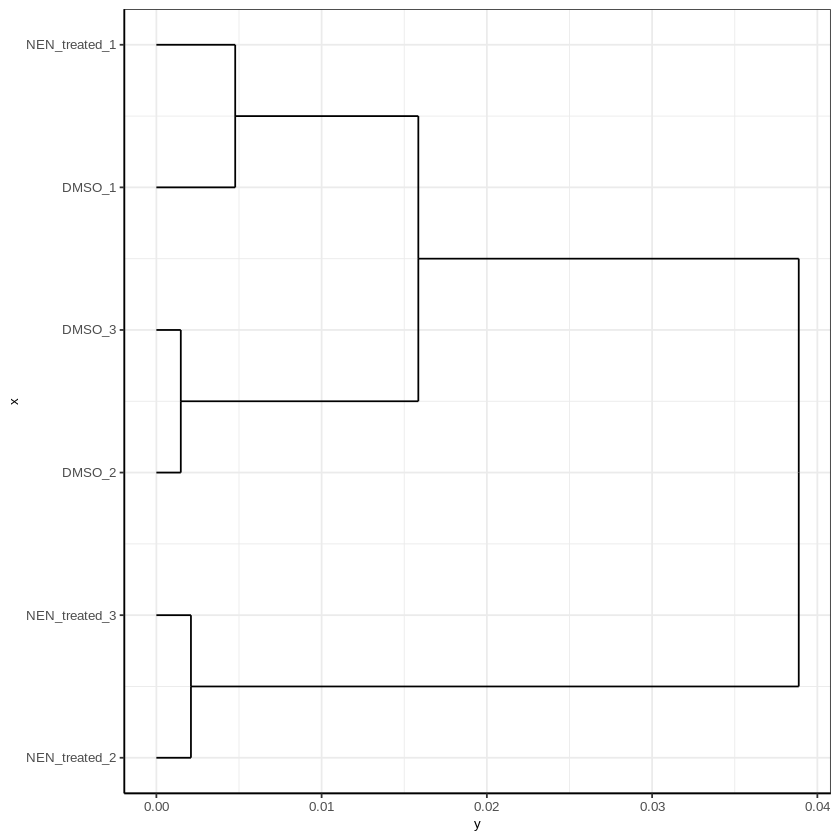


$PCAvariationPerDimension


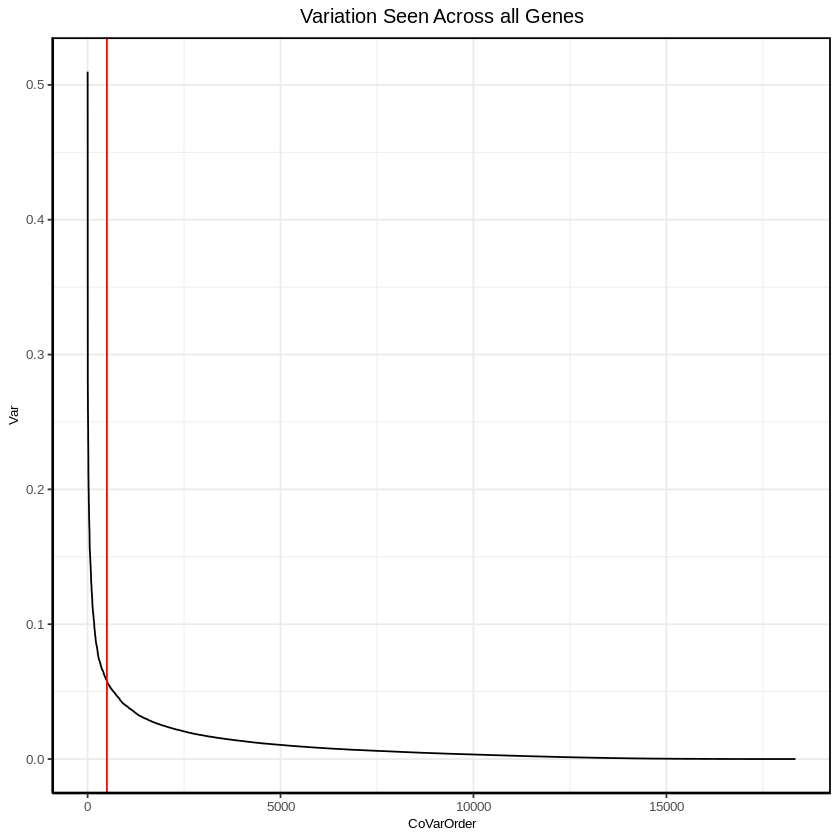

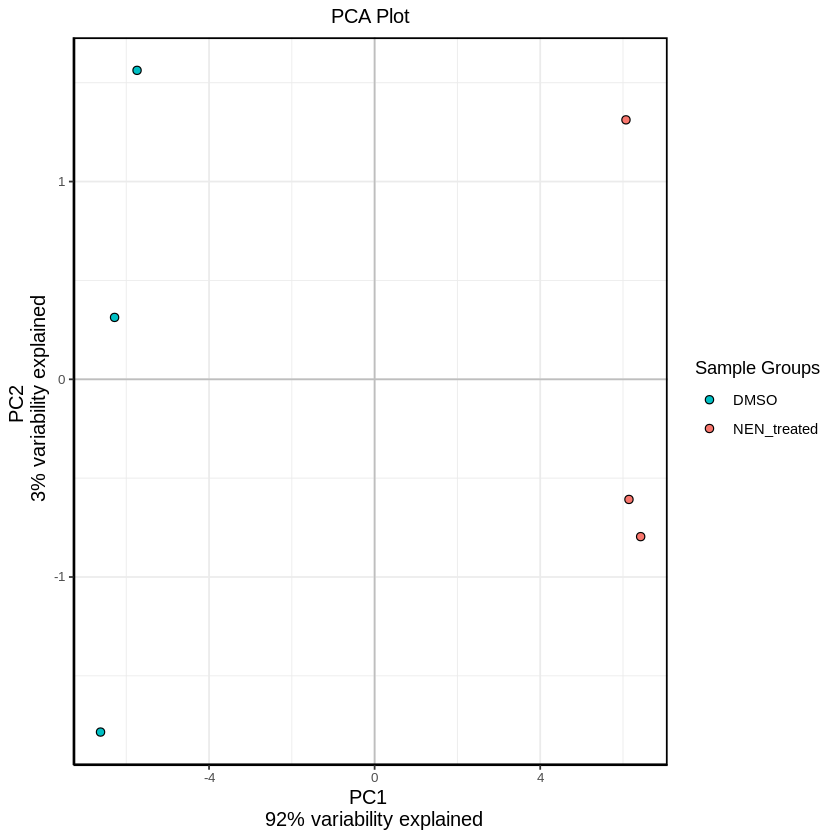

In [264]:
print(plotList)

# Plot Coefficient of Variation

In [265]:
###########################################################################
## Add Coefficient of variation plot                                     ##

if (exists("dfRv")){
    tag <- "CoVar_Plot"
    
    figureCol = "DEseq2RV"
    dfDat <- unique(
        dfRv[,c( primaryAlignmentGeneID, "DEseq2RV", "CoVar")]
    )
    dfDat[["Var"]] <- dfDat[,figureCol]
    dfDat <- dfDat[order(dfDat$Var, decreasing = TRUE),]

    dfDat <- dfDat[dfDat$Var > 0, ]
    dfDat[["CoVarOrder"]] <- 1:nrow(dfDat)
    
    

    if (!exists("NtopGene")){
         NtopGene <- length(Ntop4pcaGeneSelection)
    }

    plotList[[tag]] <- ggplot2::ggplot(
    data=dfDat,
    ggplot2::aes(x=CoVarOrder, y=Var)
) + ggplot2::geom_line( ) + ggplot2::geom_vline(xintercept = NtopGene, col="red"
) +  ggplot2::theme_bw() + ggplot2::theme(
    axis.text.y   = ggplot2::element_text(size=8),
    axis.text.x   = ggplot2::element_text(size=8),
    axis.title.y  = ggplot2::element_text(size=8),
    axis.title.x  = ggplot2::element_text(size=8),
    axis.line = ggplot2::element_line(colour = "black"),
    panel.border = ggplot2::element_rect(colour = "black", fill=NA, size=1),
    plot.title = ggplot2::element_text(hjust = 0.5, size = 12)
) + ggplot2::labs(title = paste0("Variation Seen Across all Genes")
)

    ###########################################################################
    ## Save plot to file                                                     ##
    FNbase <- paste0("CoVar", VersionPdfExt)
    FN <- paste0(figDir, FNbase)
    FNrel <- paste0("report_figures/", FNbase)

    pdf(FN)
        print(plotList[[tag]])
    dev.off()
    ##                                                                       ##
    ###########################################################################

    # link <- paste0(
    #           'An interactive version of this figure can be found ',
    #           '<a href="https://', urlString,'/',Obio@projectDetailList$project_id,'/scatterplot?x_axis=CoVarOrder&y_axis=CoVar&headline=2D+Scatterplot" target="_blank">here</a>', '. ')  
    link <- ""
    
    figLegend <- paste0(
        '**Figure ', 
        figureCount, 
        ':** ',
        ' Coefficient of variation per gene. The red line indicates the cut-off for the most variable genes in this experiment. The most variable genes are the basis for the PCA analysis and heatmap displays. Download a pdf of this figure <a href="',FNrel,'" target="_blank">here</a>. ',
     link
)
    
    

    figureCount <- figureCount + 1

    NewChnk <- paste0(
        paste0("## Coefficient of Variation \n"),
            "\n```{r CoVarPlot, results='asis', echo=F, eval=TRUE, warning=FALSE, fig.cap='",figLegend,"'}\n",
            "\n",
            "\n print(plotList[['",tag,"']])",
            "\n cat(  '\n')",
            "\n\n\n```\n"
    )

    chnkVec <- c(
        chnkVec,
        NewChnk
    )


}

## Done adding coefficient of variation                                  ##
###########################################################################
if (length(plotList) > 2){
    tabVar <- ".tabset .tabset-fade .tabset-dropdown"
} else {
    tabVar <- ".tabset .tabset-fade .tabset-pills"
}

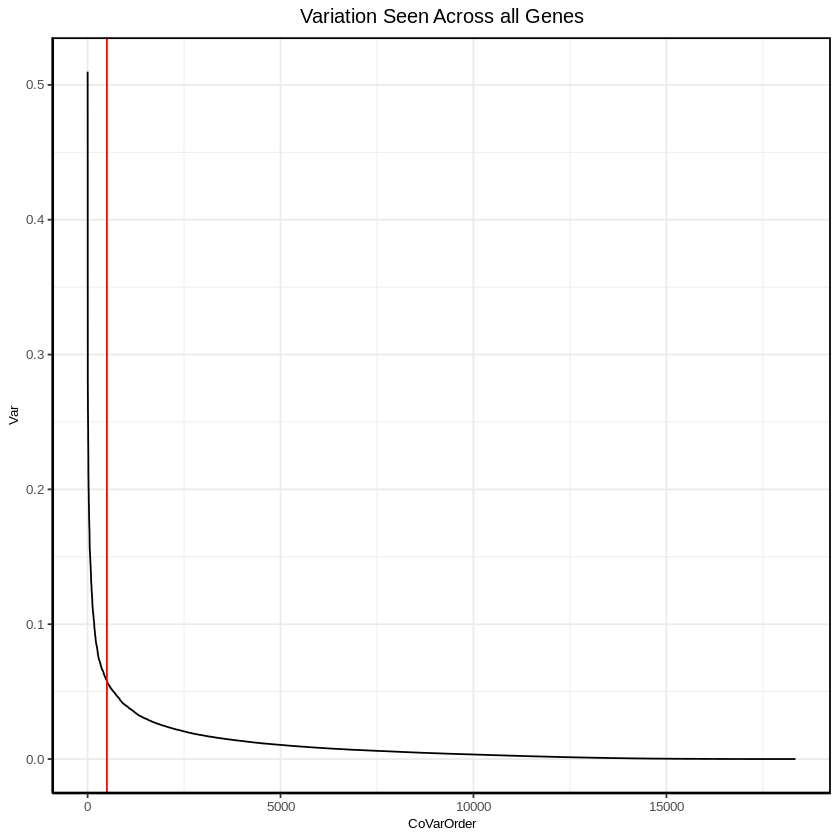

In [266]:
print(plotList[[tag]])

In [267]:
# This procedure requires the variables
# Ntop4pcaGeneSelection, project_id, primaryAlignmentGeneID, figDir, dfDesign

## Do PCA

#########################################################################
## Create DESeq2 object                                                ##

colData = unique(dfDesign[, c("sample.id", "sample.group")])
        rownames(colData) = as.vector(colData$sample.id)
        colData$sample.id <- NULL
        colnames(colData)[1] = "condition"
        colData$condition <- as.factor(colData$condition
)

dds <- DESeq2::DESeqDataSetFromMatrix(
countData = mRSEM[,row.names(colData)],
    colData   = colData,
    design    = ~ condition
)

dds <- DESeq2::estimateSizeFactors(dds)

if (length(unique(dfDesign$sample.id)) > 42) {
    rld <- DESeq2::vst(dds)
} else {
    rld <- DESeq2::rlog(dds)
}


pca = prcomp(t(SummarizedExperiment::assay(rld)[Ntop4pcaGeneSelection, ]))

PCApercentVar <- pca$sdev^2/sum(pca$sdev^2)

## Add percent variation plot ##
PercentVariation <- round(100*PCApercentVar,1)
PCdimension <- paste0("PC", 1:length(PercentVariation))
df <- data.frame(
    PercentVariation,
    PCdimension
)
df <- df[df$PercentVariation > 0,]


## Adding gene annotations ##
dfBase <- SummarizedExperiment::assay(rld)[Ntop4pcaGeneSelection, ]

dfBase <- t(dfBase)
pcaGenes = prcomp(scale(dfBase))



df.design.pca <- unique(dfDesign[,c("sample.id", "sample.group")])
df.pca = data.frame(pca$x)
df.pca[["sample.id"]] <- row.names(df.pca)

df.pca <- merge(
df.design.pca,
df.pca,
by.x = "sample.id",
by.y = "sample.id"
)

df.pca <- df.pca[order(df.pca$sample.id),]
names(df.pca) <- gsub("[.]", "_", names(df.pca))

dfPCA <- df.pca            


converting counts to integer mode



In [268]:
###############################################################################
## Add PCA plot                                                              ##


if (!exists("VersionPdfExt")){
    VersionPdfExt <- paste0(".V", gsub("-", "", Sys.Date()), ".pdf")
}



if (!exists("chnkVec")){
    chnkVec <- as.vector(NULL, mode = "character")
}

if (!exists("plotList")){
    plotList <- list()
}
    
tag <- "PCAvariationPerDimension"

## Use custom PCA colors if specified ##

## Just in case we still have dots instead of underscores
names(dfPCA) <- gsub("\\.", "_", names(dfPCA))
pcaSampleGroups <- unique(sort(dfPCA$sample_group))

## If sample.group colors are set use those, otherwise set default.
pos <- grep("^sample.group_color$", names(dfDesign))

if (length(pos) == 0){
    ## Create default ##
    sample.group <- unique(dfDesign$sample.group)
    sample.group_color <- sample.group
            #library(scales)
    sample.group_color = scales::hue_pal()(length(sample.group_color))
            #sample.group_color = c("#990000", "#009900")
    
    ## set sample group colors manually
    
    dfGroupColors <- unique(data.frame(sample.group, sample.group_color))
    dfDesign <- merge(dfDesign, dfGroupColors, by.x = "sample.group", "sample.group")
    
}

dfColor <- unique(
        dfDesign[,c("sample.group", "sample.group_color")]
)

if (nrow(dfColor) == length(pcaSampleGroups)){
  
    namedColors <- dfColor$sample.group_color
    names(namedColors) <- dfColor$sample.group
  
    plotList[[tag]] <- ggplot2::ggplot(
        data = dfPCA,
        ggplot2::aes(x=PC1, y=PC2, fill = sample_group)
    ) + ggplot2::geom_vline(xintercept = 0, color = "grey", size=0.5
    ) + ggplot2::geom_hline(yintercept = 0, color = "grey", size=0.5
    ) + ggplot2::geom_point(
        size=2,
        shape = 21
    ) + ggplot2::scale_fill_manual("Sample Groups", values = namedColors
    )
} else {
    plotList[[tag]] <- ggplot2::ggplot(
        data = dfPCA,
        ggplot2::aes(x=PC1, y=PC2, fill = sample_group)
    ) + ggplot2::geom_vline(xintercept = 0, color = "grey", size=0.5
    ) + ggplot2::geom_hline(yintercept = 0, color = "grey", size=0.5
    ) + ggplot2::geom_point(
        size=2,
        shape = 21
    ) 
}




if (!is.null(PCApercentVar)){
    plotList[[tag]] <- plotList[[tag]] + ggplot2::labs(
        title = "PCA Plot", 
        x = paste0("PC1 \n ",round(100* PCApercentVar[1]),"% variability explained"),
        y = paste0("PC2 \n ",round(100* PCApercentVar[2]),"% variability explained")
    )
} else {
    plotList[[tag]] <- plotList[[tag]] + ggplot2::labs(
        title = "PCA Plot", 
        x = paste0("PC1"),
        y = paste0("PC2")
    )
}

plotList[[tag]] <- plotList[[tag]] +  ggplot2::theme_bw() + ggplot2::theme(
        axis.text.y   = ggplot2::element_text(size=8),
        axis.text.x   = ggplot2::element_text(size=8),
        axis.title.y  = ggplot2::element_text(size=12),
        axis.title.x  = ggplot2::element_text(size=12),
        axis.line = ggplot2::element_line(colour = "black"),
        panel.border = ggplot2::element_rect(colour = "black", fill=NA, size=1),
        plot.title = ggplot2::element_text(hjust = 0.5, size = 12)
)


###########################################################################
## Save plot to file                                                     ##
FNbase <- paste0("PCA12", VersionPdfExt)
FN <- paste0(figDir, FNbase)
FNrel <- paste0("report_figures/", FNbase)
FNrelT <- paste0("report_tables/", FNbase)
    
pdf(FN)
    print(plotList[[tag]])
dev.off()
##                                                                       ##
###########################################################################

png 
  2

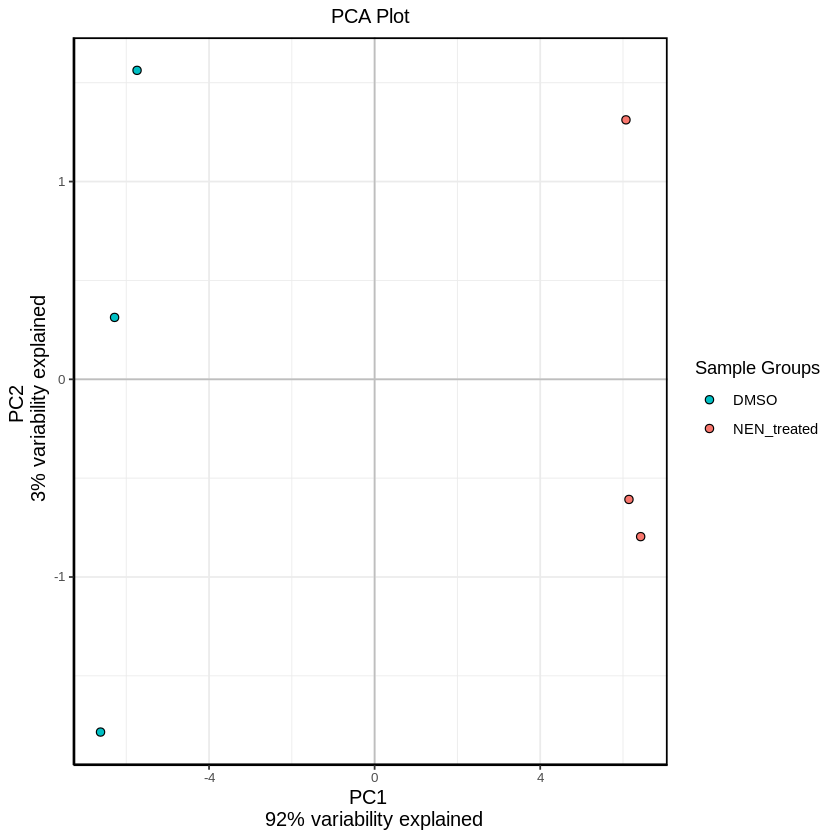

In [269]:
print(plotList[[tag]])

In [270]:
#######################################################################
## Add custon gene set(s) for heatmap plotting

# chatGPT query: make me a gene list (offical hgnc symbols) of all human g-protein coupled receptors

# Load the required package
library(biomaRt)

# Connect to the Ensembl database
ensembl <- useMart("ensembl", host = "https:/www.ensembl.org",dataset = "hsapiens_gene_ensembl")
## Alternative if the above is giving a connection error
# ensembl <- useMart("ensembl", host = "https:/useast.ensembl.org",dataset = "hsapiens_gene_ensembl")


# Retrieve the GPCR gene list
gpcr_genes <- getBM(attributes = c("hgnc_symbol"), filters = "go", values = "GO:0004930", mart = ensembl)

# Print the gene list
geneVec <- as.vector(sort(gpcr_genes[,1]))

head(geneVec)

if (!exists("HmDisplayCatsFromDb")) {
    HmDisplayCatsFromDb <- list()
}

HmDisplayCatsFromDb[["GPCR_genes"]] <- list(
          "cat_type" = "Custom",
          "data_source" = "From experiment" ,
          "cat.description.text" = "Custom gene category",
          "geneVec" = geneVec,
          "catID" = NULL,
          "comparisonID" = NULL
)
rm(geneVec)

## Get second gene set: Interferon gamma genes
# Retrieve the GPCR gene list
BM_genes <- getBM(attributes = c("hgnc_symbol"), filters = "go", values = "GO:0034341", mart = ensembl)

# Print the gene list
geneVec <- as.vector(sort(BM_genes[,1]))

head(geneVec)

if (!exists("HmDisplayCatsFromDb")) {
    HmDisplayCatsFromDb <- list()
}

HmDisplayCatsFromDb[["IFNgamma_genes"]] <- list(
          "cat_type" = "Custom",
          "data_source" = "From experiment" ,
          "cat.description.text" = "Custom gene category",
          "geneVec" = geneVec,
          "catID" = NULL,
          "comparisonID" = NULL
)
rm(geneVec)
                     




[1] "ACKR1"     "ACKR2"     "ACKR3"     "ACKR4"     "ADCYAP1R1" "ADGRA1"

[1] "ADAMTS13" "BST2"     "CALCOCO2" "CD40"     "CD74"     "CIITA"

In [271]:
## Create list with Heatmaps
dim(dfDesign)
dfDesign
dim(dfData)
dim(dfTPM)

HMplotList <- createHeatmapPlotList(
    HmDisplayCatsFromDb = HmDisplayCatsFromDb,
    dfDesign = dfDesign,
    dfData = dfData,
    dfTPM = dfTPM
)



[1] 6 5

sample.group,sample.id,comp_A1,dataset_id,sample.group_color
<chr>,<chr>,<chr>,<chr>,<chr>
DMSO,DMSO_2,2_DMSO,PRJEB23709,#00BFC4
DMSO,DMSO_1,2_DMSO,PRJEB23709,#00BFC4
DMSO,DMSO_3,2_DMSO,PRJEB23709,#00BFC4
NEN_treated,NEN_treated_2,1_NEN_treated,PRJEB23709,#F8766D
NEN_treated,NEN_treated_3,1_NEN_treated,PRJEB23709,#F8766D
NEN_treated,NEN_treated_1,1_NEN_treated,PRJEB23709,#F8766D


[1] 500   6

[1] 29972     7

In [272]:
# Available heatmaps for display:
names(HMplotList)

[1] "GPCR_genes"     "IFNgamma_genes"

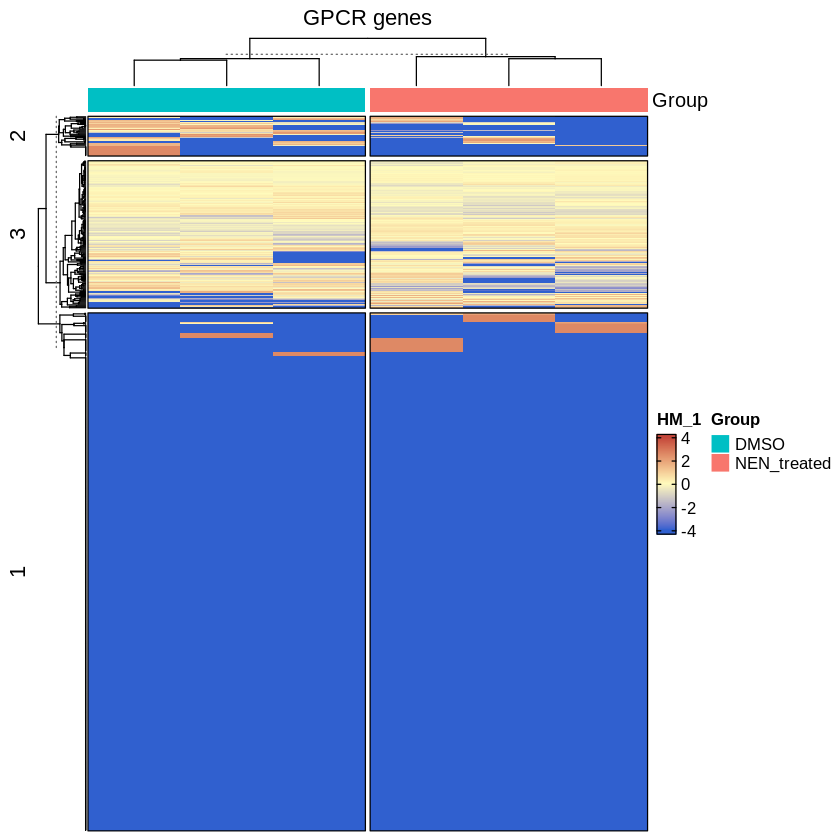

In [273]:
## Make heatmap for G-protein coupled receptor (GPCR) genes

print(HMplotList[[1]])


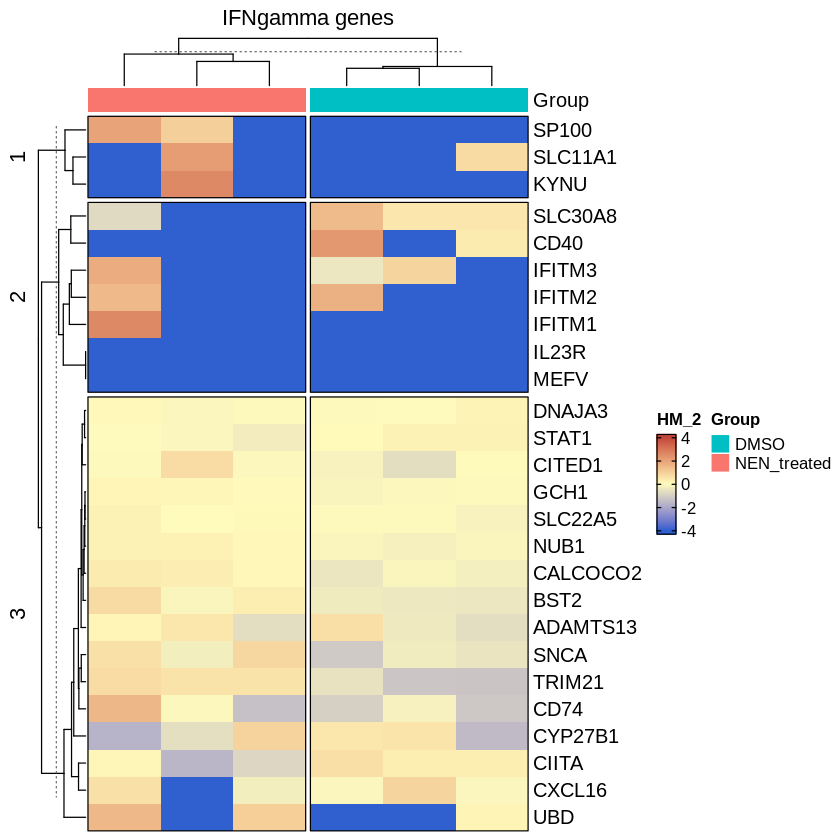

In [274]:
## Plot interferon gamma genes across all samples
print(HMplotList[[2]])

In [275]:
# Create powerpoint presentation with plots

## Create Powerpoint Slides
Powerpoint slides are exported to the ../../../../results folder. The names of the presentation is test.powerpoint.presentation.pptx.

In [276]:
pptxPlotList <- c(
    plotList,
    HMplotList
)


## Create results directory for this project if it doesn't exist. 
if (!dir.exists("../../../../results")){
    dir.create("../../../../results", recursive = TRUE)
}

## Make powerpoint presentation based on the plots collected in pptxPplotList. 
createPowerpointPresentationFromPlotList(
    pptxPlotList, 
    outputfile="../../../../results/test.powerpoint.presentation.pptx"
)

[1] "Presentation generated and saved as ../../../../results/test.powerpoint.presentation.pptx"


In [277]:
wd <- getwd()

print(paste0("This work was done in folder: ", wd))

sessionInfo()

[1] "This work was done in folder: /home/jovyan/projects/project_demo/code/rnaseqworkflow/analyses/downstream_analysis_example_workflow"


R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.04.2 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/envs/R422/lib/libopenblasp-r0.3.23.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices datasets  utils     methods   base     

other attached packages:
[1] biomaRt_2.54.1

loaded via a namespace (and not attached):
  [1] bitops_1.0-7                matrixStats_1.0.0          
  [3] bit64_4.0.5                 doParallel_1.0.17          
  [5] filelock_1.0.2              RColorBrewer_1.1-3         
  [7] progress_1.2.2              httr_1.4.6                 
  [9] Ge